<a href="https://colab.research.google.com/github/tur103/Social-Network-Link-Prediction/blob/master/Machine_Learning_With_Graph_Database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning With Graph Database

---

### Welcome to the machine learning with graph database tutorial

In this notebook you will learn how to build a machine learning based on graph databse.

In project we will use Neo4j graph database platform, pandas data science library and scikit-learn models building library to create a machine learning classifier.


## Predictions

Our machine learning model should be able to predict what would be the right answer of a given question according to what it has learn so far.

In graph database it is the ability to predict a near future connection between to entities that are currently not connected.

### This is called Link-Prediction

In other words:
Given a snapshot of a social network, can we infer which new interactions among its members are likely to occur in the near future?

In this guide we will learn how to build a machine learning classifier to predict future relationships between people in a social network.

## Database

You will need to create a clouded Neo4j database instance using Neo4j Sandbox. Its free! Here is a link for instruction: [tap on me](https://youtu.be/rmfgRKPjhl8)

After lunching your sandbox, create a blank database.

## Install Libraries

First, we need to install the following libraries for our project

In [5]:
!pip install py2neo==4.1.3 pandas matplotlib sklearn

## Start to Code

Next, we want to import our libraries into the interpreter and validate their installation.

In [0]:
from py2neo import Graph
import pandas as pd
import statistics

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

Now we need to create a connection to our graph instance using py2neo.
You will need to update the connection details to the graph according to the ones appeared in the created database on your sandbox.

In [0]:
# Change the line of code below to use the Bolt URL and Password of your Neo4j instace.
# graph = Graph("bolt://<IP Address>:<Bolt Port>", auth=("neo4j", "<Password>")) 
 
graph = Graph("bolt://54.162.238.103:32784", auth=("neo4j", "market-waste-linkages"))

## Build Social Network Graph

In order to build the social network graph database, here is a pre-prepared script that runs some cypher queries to load all the data we need into the graph.


In [80]:
index_education = """CREATE INDEX ON :Education(name)"""
index_hiring_source = """CREATE INDEX ON :HiringSource(name)"""
index_job = """CREATE INDEX ON :Job(name)"""
index_location = """CREATE INDEX ON :Location(name)"""
index_person = """CREATE INDEX ON :Person(name)"""
index_team = """CREATE INDEX ON :Team(name)"""
index_university = """CREATE INDEX ON :University(name)"""

load_person = """
LOAD CSV WITH HEADERS FROM "https://github.com/tur103/Social-Network-Link-Prediction/raw/master/data/People.csv" AS line
WITH line LIMIT 800

MERGE (person:Person {name: line.Name})
SET person += line
WITH line, person

CALL apoc.do.when(line.Retirement = "Yes",
				  'SET person:Retired RETURN person',
                  'RETURN person',
                  {line:line, person:person})
YIELD value
WITH line, value["person"] AS person

CALL apoc.do.when(line.`Is.Manager` = "Yes",
				  'SET person:Manager RETURN person',
                  'RETURN person',
                  {line:line, person:person})
YIELD value
WITH line, value["person"] AS person

CALL apoc.create.addLabels(person, [line.Sex]) YIELD node
WITH COLLECT(node) AS nodes
RETURN 1
"""
load_education = """
MATCH (person:Person)
MERGE (education:Education {name: person.`Education.Level`})
MERGE (person)-[:EDUCATION_LEVEL]->(education)
"""
load_hiring_source = """
MATCH (person:Person)
MERGE (hiring_source:HiringSource {name: person.`Hiring.Source`})
MERGE (person)-[:HIRING_SOURCE]->(hiring_source)
"""
load_job = """
MATCH (person:Person)
MERGE (job:Job {name: person.`Job.Family`})
MERGE (person)-[:JOB]->(job)
"""
load_location = """
MATCH (person:Person)
MERGE (location:Location {name: person.`Biz.Location`})
MERGE (person)-[:LOACTION]->(location)
"""
load_team = """
MATCH (person:Person)
MERGE (team:Team {name: person.Team})
MERGE (person)-[:TEAM]->(team)
"""
load_university = """
MATCH (person:Person)
MERGE (university:University {name: person.University})
MERGE (person)-[:STUDIED_AT]->(university)
"""

connect_education = """
MATCH (education:Education)
MATCH (person:Person)-[:EDUCATION_LEVEL]->(education)<-[:EDUCATION_LEVEL]-(other_person:Person)
WHERE ID(person) > ID(other_person)
MERGE (person)<-[r:RELATED {employ_id: (toInteger(person.`Emp.No`) + toInteger(other_person.`Emp.No`))}]->(other_person)
ON CREATE SET r.value = 2
ON MATCH SET r.value = r.value + 2
"""
connect_hiring_source = """
MATCH (hiring_source:HiringSource)
MATCH (person:Person)-[:HIRING_SOURCE]->(hiring_source)<-[:HIRING_SOURCE]-(other_person:Person)
WHERE ID(person) > ID(other_person)
MERGE (person)<-[r:RELATED {employ_id: (toInteger(person.`Emp.No`) + toInteger(other_person.`Emp.No`))}]->(other_person)
ON CREATE SET r.value = 1
ON MATCH SET r.value = r.value + 1
"""
connect_job = """
MATCH (job:Job)
MATCH (person:Person)-[:JOB]->(job)<-[:JOB]-(other_person:Person)
WHERE ID(person) > ID(other_person)
MERGE (person)<-[r:RELATED {employ_id: (toInteger(person.`Emp.No`) + toInteger(other_person.`Emp.No`))}]->(other_person)
ON CREATE SET r.value = 4
ON MATCH SET r.value = r.value + 4
"""
connect_location = """
MATCH (location:Location)
MATCH (person:Person)-[:LOACTION]->(location)<-[:LOACTION]-(other_person:Person)
WHERE ID(person) > ID(other_person)
MERGE (person)<-[r:RELATED {employ_id: (toInteger(person.`Emp.No`) + toInteger(other_person.`Emp.No`))}]->(other_person)
ON CREATE SET r.value = 5
ON MATCH SET r.value = r.value + 5
"""
connect_team = """
MATCH (team:Team)
MATCH (person:Person)-[:TEAM]->(team)<-[:TEAM]-(other_person:Person)
WHERE ID(person) > ID(other_person)
MERGE (person)<-[r:RELATED {employ_id: (toInteger(person.`Emp.No`) + toInteger(other_person.`Emp.No`))}]->(other_person)
ON CREATE SET r.value = 6
ON MATCH SET r.value = r.value + 6
"""
connect_university = """
MATCH (university:University)
MATCH (person:Person)-[:STUDIED_AT]->(university)<-[:STUDIED_AT]-(other_person:Person)
WHERE ID(person) > ID(other_person)
MERGE (person)<-[r:RELATED {employ_id: (toInteger(person.`Emp.No`) + toInteger(other_person.`Emp.No`))}]->(other_person)
ON CREATE SET r.value = 3
ON MATCH SET r.value = r.value + 3
"""

remove_week_connections = """
MATCH (person:Person)-[r:RELATED]->(other_person:Person)
WHERE r.value < 15
DELETE r
"""

graph.run(cypher=index_education)
graph.run(cypher=index_hiring_source)
graph.run(cypher=index_job)
graph.run(cypher=index_location)
graph.run(cypher=index_person)
graph.run(cypher=index_team)
graph.run(cypher=index_university)
graph.run(cypher=load_person)
graph.run(cypher=load_education)
graph.run(cypher=load_hiring_source)
graph.run(cypher=load_job)
graph.run(cypher=load_location)
graph.run(cypher=load_team)
graph.run(cypher=load_university)
graph.run(cypher=connect_education)
graph.run(cypher=connect_hiring_source)
graph.run(cypher=connect_job)
graph.run(cypher=connect_location)
graph.run(cypher=connect_team)
graph.run(cypher=connect_university)
graph.run(cypher=remove_week_connections)

Now that you have created the social netweok graph, you will use the link prediction algorithms to compute scores on all the people in it.

## Graph algoritms in Neo4j

Neo4j has a graph algorithms library to perform advanced manipulations on the grah and gain hidden insights from the data we already have.
Graph algorithms take into consideration the graph topology in order to extract information from the way that the entities are connected.

In this tutorial we are going to use the link prediction algorithms.
These are set of methods that compute a score for a pair of nodes, where the score could be considered a measure of proximity or “similarity” between those nodes based on the graph topology. The closer two nodes are, the more likely there will be a relationship between them.

## Link Prediction Algorithms

The uniqueness of graph database compared to relational databases gives us the ability to look at our data in a form of a network.

Instead of predict links between people based on their formal characteristics, we can predict relationships based on the connectedness of the people on the network.

While we look at the network, it's structure and the way that our entities inside it are connected to each other, we can predict connections between people based on their connection to other people.

This sort of thinkning is way more reality like. People not just become friends of othoer people at the same age or people that were learning the same subjects in collage. In real life people are creating new relationships based on common friends and belonging to a certain social circles.

Link Prediction Algorithms do exectly this!
They predict the availability of near future relationships based on the schema of the graph and the way that the entities are conencted to each other in the network.

With link predictions on graph databases we can predict new relationships in a more life-like way to gain more accurate and intelligent results.

## Supervised learning

You will take the supervised learning approach where you use the scores as features to train a binary classifier. The binary classifier then predicts whether a pair of nodes will have a link.

## Train and test datasets 

Next, you must create the train and test datasets on which you can build, and then evaluate a model.

## Positive examples

we need to split the graph into training and test sub graphs. We can split the graph according to the relationship's employ_id between people at the median. The training set will be from ID lower than the median, the test set from larger.

Subsequently, pairs of nodes in our train and test datasets will have relationships between them. They will be the __positive examples__ in your machine learning model.

Let's find out what our employ_id median is:

In [81]:
query = """
MATCH (person:Person)<-[r:RELATED]->(other_person:Person) 
WITH toInteger(person.`Emp.No`) + toInteger(other_person.`Emp.No`) AS employ_id
ORDER BY employ_id
RETURN employ_id
"""
employ_ids = graph.run(query).to_data_frame()["employ_id"]

median = statistics.median(employ_ids)
print(median)

5946.0


It looks like our employ_id median is 5946. So this is where we are going to split our datasets.

Let's create explicit `RELATED_BEFORE` and `RELATED_AFTER` relationships in the graph based on that employ_id. The following code will create these relationships:

In [82]:
query = """
MATCH (person:Person)<-[r:RELATED]->(other_person:Person) 
where toInteger(person.`Emp.No`) + toInteger(other_person.`Emp.No`) < 5946
MERGE (person)<-[new_r:RELATED_BEFORE]->(other_person)
SET new_r.value = r.value
"""

graph.run(query).stats()

{'constraints_added': 0,
 'constraints_removed': 0,
 'contains_updates': True,
 'indexes_added': 0,
 'indexes_removed': 0,
 'labels_added': 0,
 'labels_removed': 0,
 'nodes_created': 0,
 'nodes_deleted': 0,
 'properties_set': 0,
 'relationships_created': 2193,
 'relationships_deleted': 0}

In [83]:
query = """
MATCH (person:Person)<-[r:RELATED]->(other_person:Person) 
where toInteger(person.`Emp.No`) + toInteger(other_person.`Emp.No`) >= 5946
MERGE (person)<-[new_r:RELATED_AFTER]->(other_person)
SET new_r.value = r.value
"""

graph.run(query).stats()

{'constraints_added': 0,
 'constraints_removed': 0,
 'contains_updates': True,
 'indexes_added': 0,
 'indexes_removed': 0,
 'labels_added': 0,
 'labels_removed': 0,
 'nodes_created': 0,
 'nodes_deleted': 0,
 'properties_set': 0,
 'relationships_created': 2194,
 'relationships_deleted': 0}

Determine how many RELATED relationship you have in each of these sub graphs:

In [84]:
query = """
MATCH (:Person)<-[:RELATED_BEFORE]->(:Person)
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,4386


In [85]:
query = """
MATCH (:Person)<-[:RELATED_AFTER]->(:Person)
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,4388


This graph has a split of nearly 50-50, which is great! Next, we create our negative examples

## Negative examples

The simplest approach is to use all pair of nodes that don’t have a relationship. __The problem with this approach is that there are significantly more examples of pairs of nodes that don’t have a relationship than there are pairs of nodes that do__.

If you were to use all of these negative examples in your training set, you would have a massive class imbalance — there are many negative examples and relatively few positive ones.

You need to reduce the number of negative examples. An approach described in several link prediction papers is to use pairs of nodes that are a __specific number of hops away from each other__.

This will significantly reduce the number of negative examples, although there will still be a lot more negative examples than positive.

To solve this problem, you either need to down sample the negative examples or up sample the positive examples.

You will take the down sampling approach. The following function will do this:

In [0]:
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

Now you are ready to build the train and test datasets based on the train and test sub graphs that you created. 

* The positive examples will be taken directly from the graph. 
* The negative examples will be found by looking for people who are 2 or 3 hops away from each other, excluding those that have already collaborated. You will then down sample those examples to equal the size of the positive examples. 

In [0]:
train_existing_links = graph.run("""
MATCH (person:Person)<-[:RELATED_BEFORE]->(other_person:Person)
RETURN id(person) AS node1, id(other_person) AS node2, 1 AS label
""").to_data_frame()

train_missing_links = graph.run("""
MATCH (person:Person)
WHERE (person)<-[:RELATED_BEFORE]->(:Person)
MATCH (person)<-[:RELATED_BEFORE*2..3]->(other_person:Person)
WHERE not((person)<-[:RELATED_BEFORE]->(other_person))
RETURN id(person) AS node1, id(other_person) AS node2, 0 AS label
""").to_data_frame()
train_missing_links = train_missing_links.drop_duplicates()

In [0]:
training_df = train_missing_links.append(train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')
training_df = down_sample(training_df)

Now let's have a look what our train DataFrame contains:

In [87]:
training_df.head()

,node1,node2,label
26208,78,507,0
45219,583,249,1
43343,230,510,1
42384,43,767,1
5060,31,87,0


Let's repeat the process for the test set:

In [0]:
test_existing_links = graph.run("""
MATCH (person:Person)<-[:RELATED_AFTER]->(other_person:Person)
RETURN id(person) AS node1, id(other_person) AS node2, 1 AS label
""").to_data_frame()

test_missing_links = graph.run("""
MATCH (person:Person)
WHERE (person)<-[:RELATED_AFTER]->(:Person)
MATCH (person)<-[:RELATED_AFTER*2..3]->(other_person:Person)
WHERE not((person)<-[:RELATED_AFTER]->(other_person))
RETURN id(person) AS node1, id(other_person) AS node2, 0 AS label
""").to_data_frame()
test_missing_links = test_missing_links.drop_duplicates()

In [0]:
test_df = test_missing_links.append(test_existing_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')
test_df = down_sample(test_df)

And it's time to sample our test DataFrame:

In [40]:
test_df.head()

,node1,node2,label
41132,586,315,1
38643,139,660,1
15569,491,342,0
39601,321,288,1
41610,660,387,1


## Choosing a machine learning algorithm

Next, you will create a machine learning pipeline based on a random forest classifier. This method is well suited as this data set will be comprised of a mix of strong and weak features. While the weak features will sometimes be helpful, the random forest method will ensure that you don’t create a model that only fits the training data

In [0]:
classifier = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0)

# Generating graphy features

Start by creating a simple model that tries to predict whether two persons will have a future relationship based on features extracted from common neighbors, preferential attachment, and the total union of neighbors.

All of those algorithms are part of the link-prediction graph algorithms library of Neo4j but they are also a great human-like way to predict new relationships between people - People that have a lot of friends and that are very social have a great chance of meeting new friends.
In addition, if two people have a lot of common friends, they also have a very big chance that one of them will introduce the two. 

The algorithms will generate a score for each pair of nodes that indicates the similiarity between them taken from the graph topology.

Later, we will let the machine learning classifier to learn the closeness of each pair of nodes according to those generated scores.

The following function computes each of these measures for pairs of nodes:

In [0]:
def apply_graphy_features(data, rel_type):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           algo.linkprediction.commonNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS cn,
           algo.linkprediction.preferentialAttachment(
               p1, p2, {relationshipQuery: $relType}) AS pa,
           algo.linkprediction.totalNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS tn
    """
    pairs = [{"node1": node1, "node2": node2}  for node1, node2 in data[["node1", "node2"]].values.tolist()]
    features = graph.run(query, {"pairs": pairs, "relType": rel_type}).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

Now apply the function to the training DataFrame:

In [0]:
training_df = apply_graphy_features(training_df, "RELATED_BEFORE")

This is what the DataFrame looks like now:

In [44]:
training_df.head()

,node1,node2,label,cn,pa,tn,aa
0,542,80,0,2.000,378.000,37.000,0.647
1,315,34,0,0.000,243.000,36.000,0.000
2,156,126,1,11.000,156.000,14.000,4.372
3,416,668,0,0.000,24.000,10.000,0.000
4,166,190,1,13.000,256.000,19.000,4.984


Do the same to the test DataFrame:

In [0]:
test_df = apply_graphy_features(test_df, "RELATED_AFTER")

In [58]:
test_df.head()

,node1,node2,label,cn,pa,tn
0,138,272,1,0.000,2.000,3.000
1,448,657,1,3.000,32.000,9.000
2,573,228,0,0.000,52.000,17.000
3,514,230,0,0.000,315.000,36.000
4,296,176,1,3.000,75.000,17.000


Next, you will build a model based on these graphy features.

The following code builds a random forest model, evaluates it against the test dataset, and then indicates which of the features had the most importance in the model.

First, let's include only the common neighbors feature and see what happens

In [95]:
columns = ["cn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Next, you need to evaluate the model. You will compute its accuracy, precision, and recall. Then, you will return the importance of each feature used in the model. The following functions will help with this:

In [0]:
def evaluate_model(predictions, actual):
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall"],
        "Score": [accuracy_score(actual, predictions), 
                  precision_score(actual, predictions), 
                  recall_score(actual, predictions)]
    })

def feature_importance(columns, classifier):        
    display("Feature Importance")
    df = pd.DataFrame({
        "Feature": columns,
        "Importance": classifier.feature_importances_
    })
    df = df.sort_values("Importance", ascending=False)    
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
    ax.xaxis.set_label_text("")
    plt.tight_layout()
    plt.show()

,Measure,Score
0,Accuracy,0.855
1,Precision,0.917
2,Recall,0.780


'Feature Importance'

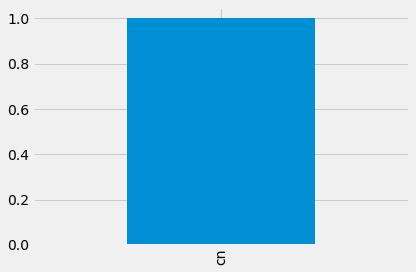

In [97]:
predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

So, we let the classifier to learn when two persons are connceted to each other based on just how many common friends they have.

The scores for accuracy and precision are adequate, but the recall is not very good.

But that is not enough.
What happens if you include more algorithms to our learning and let our classifier information gathered from other aspects of our graph topology like preferential attachment and total neighbors as well?

,Measure,Score
0,Accuracy,0.876
1,Precision,0.908
2,Recall,0.836


'Feature Importance'

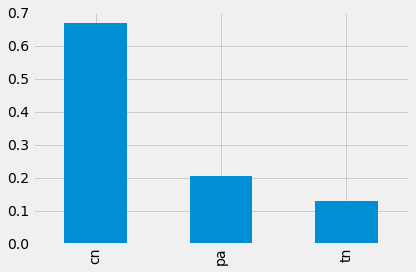

In [98]:
columns = ["cn",  "pa", "tn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

Common neighbors is the dominant feature, but including the two other features has improved the accuracy and recall of the model.

Next, you will add some new features that are generated from graph algorithms.

## Triangles and The Clustering Coefficient

Start by running the triangle count algorithm over the test and train sub-graphs. This algorithm will return the number of triangles that each node forms, as well as each node's clustering coefficient. The clustering coefficient of a node indicates the likelihood that its neighbors are also connected.

The triangle algorithms are important for our learning because person that have a lot of pair of friends that are also friends with each other have a larger chance to introduce their other friends to each other.

In [99]:
graph.run("""
CALL algo.triangleCount('Person', 'RELATED_BEFORE', { write:true,
writeProperty:'trianglesTrain', clusteringCoefficientProperty:'coefficientTrain'});
""").to_data_frame()

,loadMillis,computeMillis,writeMillis,postProcessingMillis,nodeCount,triangleCount,averageClusteringCoefficient,p1,p5,p10,p25,p50,p75,p90,p95,p99,p100,write,writeProperty,clusteringCoefficientProperty
0,4,3,0,6,800,4511,0.453,0,0,0,0,2,18,57,82,168,214,True,trianglesTrain,coefficientTrain


In [100]:
graph.run("""
CALL algo.triangleCount('Person', 'RELATED_AFTER', { write:true,
writeProperty:'trianglesTest', clusteringCoefficientProperty:'coefficientTest'});
""").to_data_frame()

,loadMillis,computeMillis,writeMillis,postProcessingMillis,nodeCount,triangleCount,averageClusteringCoefficient,p1,p5,p10,p25,p50,p75,p90,p95,p99,p100,write,writeProperty,clusteringCoefficientProperty
0,3,3,0,6,800,4975,0.429,0,0,0,0,3,15,67,103,165,191,True,trianglesTest,coefficientTest


The following function will add these features to the train and test DataFrames:

In [0]:
def apply_triangles_features(data, triangles_prop, coefficient_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]]) AS minTriangles,
    apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]]) AS maxTriangles,
    apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]]) AS minCoefficient,
    apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]]) AS maxCoefficient
    """    
    pairs = [{"node1": node1, "node2": node2}  for node1, node2 in data[["node1", "node2"]].values.tolist()]    
    params = {
    "pairs": pairs,
    "trianglesProp": triangles_prop,
    "coefficientProp": coefficient_prop
    }
    features = graph.run(query, params).to_data_frame()    
    return pd.merge(data, features, on = ["node1", "node2"])

Add the new features:

In [0]:
training_df = apply_triangles_features(training_df, "trianglesTrain", "coefficientTrain")
test_df = apply_triangles_features(test_df, "trianglesTest", "coefficientTest")

In [0]:
training_df.head()

In [0]:
test_df.head()

And now let's train and evaluate a model with these features:

And now let's train and evaluate a model with these features:

,Measure,Score
0,Accuracy,0.908
1,Precision,0.935
2,Recall,0.877


'Feature Importance'

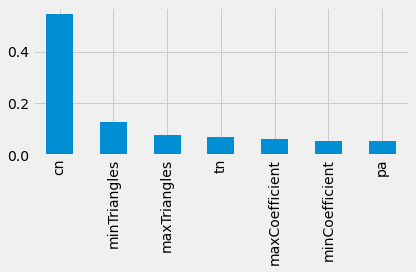

In [103]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient" # triangle features  
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

The coefficient features have not added much to our model, but the triangles are useful.

All the measures of our model are now higher then before so this triangles features improved our machine learning accuracy.

Next you will see if Community Detection algorithms can help improve the model.

## Community Detection
Community Detection algorithms evaluate how a group is clustered or partitioned. Nodes are considered more similar to nodes that fall in their community than to nodes in other communities.

For our matters, community detection graph algorithms would devide our social network into groups of social circles.
People in the same circle would have strong connection to other prople in their circle.

Those algorithms will teach our classifier about the conectedness of our entities in a very life-like way - Perople have big chances to become friend that are inside their social circle.

You will run two Community Detection algorithms over the train and test sub-graphs - Label Propagation and Louvain. First, Label Propagation:

In [104]:
graph.run("""
CALL algo.labelPropagation("Person", "RELATED_BEFORE", "BOTH",
{partitionProperty: "partitionTrain"});
""").to_data_frame()

,loadMillis,computeMillis,writeMillis,postProcessingMillis,nodes,communityCount,iterations,didConverge,p1,p5,p10,p25,p50,p75,p90,p95,p99,p100,weightProperty,write,partitionProperty,writeProperty
0,42,6,0,5,800,263,1,False,1,1,1,1,1,3,7,13,21,31,weight,True,partitionTrain,partitionTrain


In [105]:
graph.run("""
CALL algo.labelPropagation("Person", "RELATED_AFTER", "BOTH",
{partitionProperty: "partitionTest"});
""").to_data_frame()

,loadMillis,computeMillis,writeMillis,postProcessingMillis,nodes,communityCount,iterations,didConverge,p1,p5,p10,p25,p50,p75,p90,p95,p99,p100,weightProperty,write,partitionProperty,writeProperty
0,6,2,0,3,800,265,1,False,1,1,1,1,1,3,8,12,20,25,weight,True,partitionTest,partitionTest


And now Louvain. The Louvain algorithm returns intermediate communities, which are useful for finding fine grained communities that exist in a graph. You will add a property to each node containing the community revealed on the first iteration of the algorithm:

In [106]:
graph.run("""
CALL algo.louvain.stream("Person", "RELATED_BEFORE", {includeIntermediateCommunities:true})
YIELD nodeId, community, communities
WITH algo.getNodeById(nodeId) AS person, communities[0] AS smallestCommunity
SET person.louvainTrain = smallestCommunity;
""").stats()

{'constraints_added': 0,
 'constraints_removed': 0,
 'contains_updates': True,
 'indexes_added': 0,
 'indexes_removed': 0,
 'labels_added': 0,
 'labels_removed': 0,
 'nodes_created': 0,
 'nodes_deleted': 0,
 'properties_set': 800,
 'relationships_created': 0,
 'relationships_deleted': 0}

In [107]:
graph.run("""
CALL algo.louvain.stream("Person", "RELATED_AFTER", {includeIntermediateCommunities:true})
YIELD nodeId, community, communities
WITH algo.getNodeById(nodeId) AS person, communities[0] AS smallestCommunity
SET person.louvainTest = smallestCommunity;
""").stats()

{'constraints_added': 0,
 'constraints_removed': 0,
 'contains_updates': True,
 'indexes_added': 0,
 'indexes_removed': 0,
 'labels_added': 0,
 'labels_removed': 0,
 'nodes_created': 0,
 'nodes_deleted': 0,
 'properties_set': 800,
 'relationships_created': 0,
 'relationships_deleted': 0}

The following function will add these features to the train and test DataFrames:

In [0]:
def apply_community_features(data, partition_prop, louvain_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    algo.linkprediction.sameCommunity(p1, p2, $partitionProp) AS sp,    
    algo.linkprediction.sameCommunity(p1, p2, $louvainProp) AS sl
    """
    pairs = [{"node1": node1, "node2": node2}  for node1, node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "partitionProp": partition_prop,
    "louvainProp": louvain_prop
    }
    features = graph.run(query, params).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [0]:
training_df = apply_community_features(training_df, "partitionTrain", "louvainTrain")
test_df = apply_community_features(test_df, "partitionTest", "louvainTest")

In [0]:
training_df.head()

In [0]:
test_df.head()

,Measure,Score
0,Accuracy,0.924
1,Precision,0.959
2,Recall,0.885


'Feature Importance'

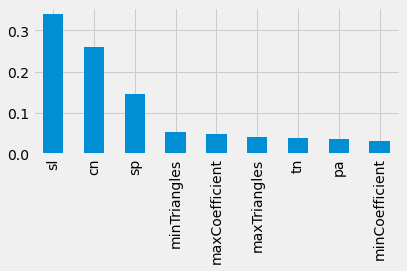

In [110]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient", # triangle features  
    "sp", "sl" # community features
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

Now let's add some more algorithms and see how they change our results.

The next algorithms we are going to use is the link prediction algorithm AdamicAdar. This algorithm will generate a score that indicates how close two entities are in the network according to the graph topology and the way that they are represented in the network structure and what is the chance for them to be conencted.

In [0]:
def apply_adamicadar_link_prediction_feature(data, rel_type):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           algo.linkprediction.adamicAdar(
               p1, p2, {relationshipQuery: $relType}) AS aa
    """
    pairs = [{"node1": node1, "node2": node2}  for node1, node2 in data[["node1", "node2"]].values.tolist()]
    features = graph.run(query, {"pairs": pairs, "relType": rel_type}).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [0]:
training_df = apply_adamicadar_link_prediction_feature(training_df, "RELATED_BEFORE")
test_df = apply_adamicadar_link_prediction_feature(test_df, "RELATED_AFTER")

In [113]:
training_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient,sp,sl,aa
0,229,504,0,0.000,33.000,14.000,3,39,0.709,1.000,0.000,0.000,0.000
1,219,750,1,3.000,50.000,12.000,7,10,0.222,0.700,1.000,1.000,1.583
2,749,392,0,0.000,5.000,6.000,0,10,0.000,1.000,0.000,0.000,0.000
3,577,781,0,1.000,66.000,16.000,10,29,0.527,0.667,0.000,0.000,0.315
4,81,458,1,6.000,121.000,16.000,24,28,0.436,0.509,1.000,1.000,2.572


In [114]:
test_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient,sp,sl,aa
0,268,571,0,0.000,60.000,23.000,0,117,0.000,0.616,0.000,0.000,0.000
1,28,306,1,0.000,80.000,24.000,3,99,0.500,0.521,0.000,0.000,0.000
2,211,726,0,1.000,105.000,21.000,6,90,0.286,0.857,0.000,0.000,0.311
3,300,439,0,2.000,273.000,32.000,37,165,0.474,0.786,0.000,0.000,0.855
4,55,76,1,16.000,414.000,25.000,95,102,0.403,0.621,1.000,1.000,6.519


,Measure,Score
0,Accuracy,0.920
1,Precision,0.952
2,Recall,0.884


'Feature Importance'

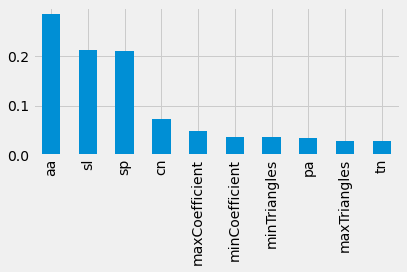

In [122]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient", # triangle features  
    "sp", "sl", # community features
    "aa" # AdamicAdar link prediction features
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

We can see that the AdamicAdar algorithm is now the most important feature for our machine learning although it did not much changed the accuracy.

## Centrality Algorithms

The last algorithm that we will try in our machine learning model is a centrallity or importance graph algorithm called PageRank.

This algorithm computes how well connected a node is in the graph and how close it is to the central mass of the network.

Each node gets a score based on how important it is in the network - how many flows of connections are getting out of it which is like how social influencive a person is.

We will add the score of this algorithm to our classifier

In [127]:
graph.run("""
CALL algo.pageRank('Person', 'RELATED_BEFORE',{
  write: true, writeProperty:"pagerankTrain", weightProperty: "value"
})
YIELD nodes, iterations, loadMillis, computeMillis, writeMillis, dampingFactor, write, writeProperty
""").to_data_frame()

,nodes,iterations,loadMillis,computeMillis,writeMillis,dampingFactor,write,writeProperty
0,800,20,9,14,3,0.850,True,pagerankTrain


In [128]:
graph.run("""
CALL algo.pageRank('Person', 'RELATED_AFTER',{
  write: true, writeProperty:"pagerankTest", weightProperty: "value"
})
YIELD nodes, iterations, loadMillis, computeMillis, writeMillis, dampingFactor, write, writeProperty
""").to_data_frame()

,nodes,iterations,loadMillis,computeMillis,writeMillis,dampingFactor,write,writeProperty
0,800,20,4,3,9,0.850,True,pagerankTest


In [0]:
def apply_centrallity_features(data, pagerank_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    apoc.coll.min([p1[$pagerank_prop], p2[$pagerank_prop]]) AS minPagerank,
    apoc.coll.max([p1[$pagerank_prop], p2[$pagerank_prop]]) AS maxPagerank
    """    
    pairs = [{"node1": node1, "node2": node2}  for node1, node2 in data[["node1", "node2"]].values.tolist()]    
    params = {
    "pairs": pairs,
    "pagerank_prop": pagerank_prop
    }
    features = graph.run(query, params).to_data_frame()    
    return pd.merge(data, features, on = ["node1", "node2"])

In [0]:
training_df = apply_centrallity_features(training_df, "pagerankTrain")
test_df = apply_centrallity_features(test_df, "pagerankTest")

In [130]:
training_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient,sp,sl,aa,minPagerank,maxPagerank
0,229,504,0,0.000,33.000,14.000,3,39,0.709,1.000,0.000,0.000,0.000,0.150,0.260
1,219,750,1,3.000,50.000,12.000,7,10,0.222,0.700,1.000,1.000,1.583,0.343,0.802
2,749,392,0,0.000,5.000,6.000,0,10,0.000,1.000,0.000,0.000,0.000,0.150,0.730
3,577,781,0,1.000,66.000,16.000,10,29,0.527,0.667,0.000,0.000,0.315,0.255,0.466
4,81,458,1,6.000,121.000,16.000,24,28,0.436,0.509,1.000,1.000,2.572,0.168,0.300


In [131]:
test_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient,sp,sl,aa,minPagerank,maxPagerank
0,268,571,0,0.000,60.000,23.000,0,117,0.000,0.616,0.000,0.000,0.000,0.187,0.316
1,28,306,1,0.000,80.000,24.000,3,99,0.500,0.521,0.000,0.000,0.000,0.150,0.435
2,211,726,0,1.000,105.000,21.000,6,90,0.286,0.857,0.000,0.000,0.311,0.157,0.662
3,300,439,0,2.000,273.000,32.000,37,165,0.474,0.786,0.000,0.000,0.855,0.230,0.329
4,55,76,1,16.000,414.000,25.000,95,102,0.403,0.621,1.000,1.000,6.519,0.150,0.236


,Measure,Score
0,Accuracy,0.920
1,Precision,0.954
2,Recall,0.883


'Feature Importance'

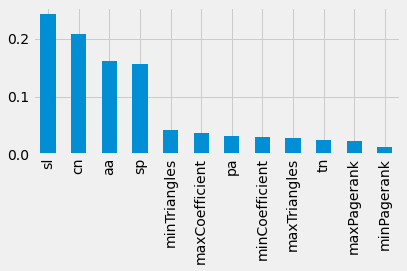

In [132]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient", # triangle features  
    "sp", "sl", # community features
    "aa", # AdamicAdar link prediction features
    "minPagerank", "maxPagerank" # Centrallity features
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

In this point we can play a little with our model and try to remove some algorithms to see how the machine learning accuracy changes.

Then we can come up with the right amount of algorithms for the best accuracy.

In addition, removing too much algorithms is not so good even if the accuracy raises because less algorithm types mean less flexability for our model to predict different structures of networks so the right balance between accuracy and flexability is need to be found.

### Summary

We built a machine learning model based on feature we extracted from our graph database.

The extracted features are scores generated by graph algorithms that computed the possiblity of two nodes to be connected or for a specific node to gain new connections.

Thanks to the social network formed from our graph database the scores are highly reality-like in predicting relationships between new human-beings.

The algorithms took into acount how many friends one have, how influencive he is in the social network, how many common friends there are between two people, what are the social circles designed from the graph and what circle each one is part of, how likely a person to connect to of his friends to each other, etc.

All of this network learning gained us the availability to know how likely two people are to get connected in the near future.

Then we entered all of those scores into our machine learning classifier and let it learn the patterns.

After that we tested the classifier with our test sub-graph and checked our accuracy, precision and recal with the importance of each feature in the model.